In [3]:
import glob
import pandas as pd
import os
import io
import re
import csv
import json
import numpy as np
from numpy import savetxt, loadtxt, asarray
from tqdm import tqdm
import math
import ast
import copy
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import datasets, layers, models
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from progressbar import ProgressBar
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Model
from random import randrange
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from keras.utils.vis_utils import plot_model
import time
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.externals import joblib 
#import eli5
#from eli5.sklearn import PermutationImportance
from keras.constraints import Constraint
import keras.backend as K
from plot_figures import save_model
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import sklearn.preprocessing as preprocessing
pbar = ProgressBar()
tqdm.pandas()

import sys
sys.path.append('../nas-search')
#sys.path.append('../../nas-search')
import predictor_parameters
import get_network_search_phase
from get_network_search_phase import TreatNeuralNetwork_searchphase
from predictor_parameters import TreatNeuralNetwork
from IPython.display import display, HTML

Using TensorFlow backend.


In [4]:
# Parameters

In [5]:


max_blocks = 37 #(36 + 1 FC layer at the end)
nb_param =7
nb_hw_param = 12


inversed = True
only_inversed = False


BATCH_SIZE = 2048
SHUFFLE_BUFFER_SIZE = 100

DATASET_SIZE = 168308
train_size = int(0.90 * DATASET_SIZE) #135 805
test_size = int(0.10 * DATASET_SIZE) # 15 089

nb_training_batches = train_size //BATCH_SIZE +1
nb_test_batches = test_size //BATCH_SIZE +1

In [6]:

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.asarray(ast.literal_eval(array_string))

# Load Proccessed Neural Networks (without HyperParameters)

### Aws paths

In [7]:
%pycache
path_raw_val = '/data_predictor/good_data/parsed_nondups_val_3.csv'
path_raw_train = '/data_predictor/good_data/parsed_nondups_train_3.csv'
path_processed_val_nn = '/data_predictor/good_data/val7_from1600.csv'
path_processed_train_nn = '/data_predictor/good_data/train7_from1600.csv'
all_nets = '/data_predictor/good_data/all_nets.json'
more_nets = '/data_predictor/good_data/more_nets'


UsageError: Line magic function `%pycache` not found.


### Local paths

In [8]:

path_raw_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/parsed_nondups_val_3.csv'
path_raw_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/parsed_nondups_train_3.csv'
path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/val7_from1600.csv'
path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/good_data/train7_from1600.csv'
all_nets = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/DataForHASpredictor2/all_nets.json'
more_nets = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/DataForHASpredictor2'


# 1) Load the processed netwroks

In [9]:
#%pycache
tin= time.clock()

    
val = pd.read_csv(path_processed_val_nn,converters={'NN_dataframe': from_np_array})
train = pd.read_csv(path_processed_train_nn,converters={'NN_dataframe': from_np_array})

tfin= time.clock()
print(f'Total time : {(tfin-tin)/60} min')

Total time : 1.5312151999999999 min


## Complete to zeros (max shape)

In [10]:
def get_shape(arr):
    return arr.shape[0]

def add_zero_blocks(arr):
    zero_blocks = np.zeros((max_blocks-arr.shape[0],arr.shape[1]))
    return np.append(arr, zero_blocks, axis=0)

val["nb_blocks"] = val["NN_dataframe"].apply(lambda x : get_shape(x))
train["nb_blocks"] = train["NN_dataframe"].apply(lambda x : get_shape(x))


val['NN_dataframe']= val['NN_dataframe'].apply(lambda x : add_zero_blocks(x))
train['NN_dataframe']= train['NN_dataframe'].apply(lambda x : add_zero_blocks(x))



## Get y_train, y_val


In [11]:


train_hw = pd.read_csv(path_raw_train)
val_hw = pd.read_csv(path_raw_val)

y_train = np.array(train_hw["total_power"].tolist())
y_train=y_train.reshape(y_train.shape[0],-1)

y_val = np.array(val_hw["total_power"].tolist())
y_val=y_val.reshape(y_val.shape[0],-1)

In [12]:
y_train_core = np.array(train_hw["core_power"].tolist())
y_train_core=y_train_core.reshape(y_train_core.shape[0],-1)

y_val_core = np.array(val_hw["core_power"].tolist())
y_val_core=y_val_core.reshape(y_val_core.shape[0],-1)

y_train_bw = np.array(train_hw["bw_power"].tolist())
y_train_bw=y_train_bw.reshape(y_train_bw.shape[0],-1)

y_val_bw = np.array(val_hw["bw_power"].tolist())
y_val_bw=y_val_bw.reshape(y_val_bw.shape[0],-1)

In [13]:
val_hw.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,G,C,B,J,name,bw_power,core_power,total_power
0,37.0,2.0,128.0,199936.0,4098.0,3.553763e+06,17433883.0,5580580.0,0.000253,6.0,22.322320,10.139486,32.461806
1,91.0,2.0,256.0,119936.0,2048.0,2.623574e+06,9725836.0,7736392.0,0.000235,6.0,30.945568,9.389513,40.335081
2,74.0,2.0,256.0,139904.0,1024.0,2.813366e+06,9984375.0,5734899.0,0.000242,6.0,22.939596,9.696341,32.635937
3,70.0,2.0,512.0,80000.0,512.0,1.922383e+06,9830611.0,9651587.0,0.000304,6.0,38.606348,12.169227,50.775575
4,103.0,2.0,256.0,199936.0,4098.0,3.887842e+06,8815844.0,5580580.0,0.000225,6.0,22.322320,8.995866,31.318186


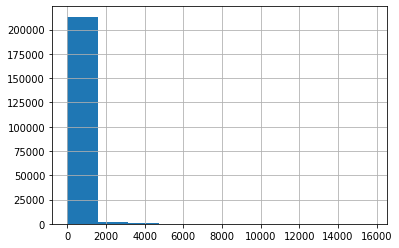

In [14]:
train_hw["total_power"].hist()

--------
# 2) Load the hardware (HW) parameters and normalize them 

In [15]:
X_train_hw_param  = train_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
#X_train_hw_param['tot_mac'] = X_train_hw_param['mac_num']*X_train_hw_param['mac_array_num']

X_val_hw_param  = val_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
#X_val_hw_param['tot_mac'] = X_val_hw_param['mac_num']*X_val_hw_param['mac_array_num']

X_train_hw_param.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size
0,118.0,2.0,256.0,179968.0,2048.0
1,87.0,2.0,512.0,99968.0,2048.0
2,124.0,2.0,512.0,99968.0,3072.0
3,80.0,2.0,1024.0,99968.0,1024.0
4,86.0,2.0,512.0,60000.0,1536.0


## HW Normalize

In [16]:
# normalize

#%pycache
# Process
scaler = preprocessing.StandardScaler(with_mean=True).fit(X_train_hw_param)
X_train_hw_param_norm= scaler.transform(X_train_hw_param)
X_val_hw_param_norm = scaler.transform(X_val_hw_param )


In [17]:
X_val_hw_param_norm

array([[-0.59586281, -0.48979288, -0.84129587,  0.75435317,  2.06166894],
       [ 0.37180672, -0.48979288, -0.64701457, -0.14792693,  0.33299414],
       [ 0.06717002, -0.48979288, -0.64701457,  0.07728218, -0.53050001],
       ...,
       [ 0.85564148,  1.46849575, -0.25845197,  1.88184238,  1.19648828],
       [ 1.37531585,  0.16297   , -0.84129587,  2.78412248,  2.06166894],
       [-0.90049951, -0.22868773, -0.64701457, -0.82391518,  1.19648828]])

# Save the Scaler

In [18]:
#%pycache
#joblib.dump(scaler, '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/params/hw_scaler.pkl') 

In [19]:
pd.DataFrame(X_val_hw_param_norm).head()

,0,1,2,3,4
0,-0.595863,-0.489793,-0.841296,0.754353,2.061669
1,0.371807,-0.489793,-0.647015,-0.147927,0.332994
2,0.067170,-0.489793,-0.647015,0.077282,-0.530500
3,-0.004509,-0.489793,-0.258452,-0.598345,-0.962247
4,0.586844,-0.489793,-0.647015,0.754353,2.061669


------------

#  3) Normalize the Neural Network parameters

In [20]:


X_train_nn =np.array(train['NN_dataframe'].tolist())
X_val_nn = np.array(val['NN_dataframe'].tolist())

## NN Normalize

### Divde columns by standard deviation

In [21]:


means = []
std = []
X_train_nn_norm=X_train_nn.copy()
X_val_nn_norm = X_val_nn.copy()
for i in range(nb_param):
    std.append(np.std(X_train_nn[:,:,i]))
    if std[i]!=0:
        X_train_nn_norm[:,:,i]/= std[i]
        X_val_nn_norm[:,:,i]/= std[i]  

#std = loadtxt('std.csv', delimiter=',')

## The standard deviations must be saved in order to renormalize the network during nas search

In [22]:
std
#savetxt('std.csv', std, delimiter=',')

[277884802.5673081,
 461103.7972515926,
 136894.47844820443,
 138975.80512235846,
 311.8400298266541,
 12.189058828019654,
 0.394164309098097]

In [23]:
pd.DataFrame(X_train_nn_norm[3000]).head()

,0,1,2,3,4,5,6
0,0.021939,0.000547,1.099591,0.812343,0.009620,0.738367,0.000000
1,0.007313,0.000195,0.824694,0.812343,0.028861,0.738367,0.000000
2,0.017876,0.000477,0.824694,1.985727,0.028861,0.082041,0.000000
3,0.583944,0.014639,2.015918,1.624686,0.423294,0.738367,0.000000
4,0.595590,0.014795,1.649387,1.624686,0.346331,2.051020,2.537013


# 3) Define two datasets (HW_params + NN arrays)

### Single output dataset

In [25]:
#NORMED
train_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_train_nn_norm, X_train_hw_param_norm), y_train))
test_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_val_nn_norm, X_val_hw_param_norm), y_val))

train_dataset_norm = train_dataset_norm.shuffle(SHUFFLE_BUFFER_SIZE)
test_dataset_norm = test_dataset_norm.shuffle(SHUFFLE_BUFFER_SIZE)

train_dataset_norm = train_dataset_norm.batch(BATCH_SIZE)
test_dataset_norm = test_dataset_norm.batch(BATCH_SIZE)




### Multiple outputs dataset

In [26]:


train_powers = np.concatenate((y_train_bw,y_train_core), axis=1)
val_powers = np.concatenate((y_val_bw,y_val_core), axis=1)

train_dataset_mult = tf.data.Dataset.from_tensor_slices ( ((X_train_nn_norm, X_train_hw_param_norm), train_powers ))
test_dataset_mult = tf.data.Dataset.from_tensor_slices( (( X_val_nn_norm, X_val_hw_param_norm), val_powers ))

train_dataset_mult = train_dataset_mult.shuffle(SHUFFLE_BUFFER_SIZE)
test_dataset_mult = test_dataset_mult.shuffle(SHUFFLE_BUFFER_SIZE)

train_dataset_mult = train_dataset_mult.batch(BATCH_SIZE)
test_dataset_mult = test_dataset_mult.batch(BATCH_SIZE)


### Losses (single/multiple outputs)

In [27]:
def loss_1(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

def loss_2(target_power, predicted_power):
  return tf.math.abs((target_power[:,0] - predicted_power[:,0])/target_power[:,0]) +tf.math.abs((target_power[:,1] - predicted_power[:,1])/target_power[:,1])




# 5) Define the model "recover" layer

### Constraint range for the HW params

In [28]:
stats =pd.DataFrame(X_train_hw_param_norm).describe()


In [29]:
min_values =list(stats.loc["min"])

In [30]:
max_values =list(stats.loc["max"])

## Create constraint class for HW params

In [31]:
class Between(Constraint):
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value
        

    def __call__(self, w):
        weights = []
        for i in range(len(self.min_value)):
            weights.append(K.clip(w[i], self.min_value[i], self.max_value[i]))
        return tf.stack([weights[0],weights[1],weights[2],weights[3],weights[4]])
        #return tf.stack([weights[0],weights[1],weights[2],weights[3],weights[4],weights[5]])


    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}

## Recover Layer to regress on the HW Params

In [32]:
class Recover(layers.Layer):
    def __init__(self, **kwargs):
        super(Recover, self).__init__(**kwargs)
        self.reverse = False

    def build(self, input_shape):
        #<tf.Variable 'recover_6/kernel:0' shape=(12,) dtype=float32>
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1],),
                                      initializer='uniform',
                                      trainable=True,
                                      constraint = Between(min_values,max_values))
                                      #constraint =tf.keras.constraints.NonNeg())
        super(Recover, self).build(input_shape)

    def call(self, x):
        if self.reverse:
            return K.ones_like(x)*self.kernel
        else:          
            return x
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[0])


# 6)  Define and train the model

In [33]:
last_layer = 128
nb_hw_param = 5

multiple_power = False


if multiple_power ==True :
    output_shape = 2
    train_dataset = train_dataset_mult
    test_dataset = test_dataset_mult
    loss = loss_2
else :
    output_shape = 1
    train_dataset = train_dataset_norm
    test_dataset = test_dataset_norm
    loss = loss_1

#NN BRANCH
input_nn = Input(shape=(max_blocks, nb_param), dtype='float32', name='input_nn')
output_nn = layers.LSTM(128, return_sequences=True)(input_nn)
output_nn=layers.Dense(last_layer,  activation='relu')(output_nn)
output_nn =tf.keras.layers.Lambda( lambda x: K.sum(x, axis=1))(output_nn)


#HW BRANCH
input_hw = Input(shape=(nb_hw_param,), dtype='float32', name='input_hw')
output_hw = Recover()(input_hw)
#output_hw = input_hw

#IF TOT_MAC :
tot_mac= input_hw[:,0]*input_hw[:,1]
tot_mac=tf.reshape(tot_mac, (tf.shape(tot_mac)[0],1))
output_hw =  tf.keras.layers.Concatenate()([output_hw, tot_mac])  

inv_hw = tf.keras.layers.Lambda( lambda x: 1/x)(output_hw)
output_hw =  tf.keras.layers.Concatenate()([output_hw, inv_hw])
output_hw = layers.Dense(128, activation='relu')(output_hw)
output_hw = layers.Dense(last_layer, activation='linear')(output_hw)

#JUNCTION BRANCH
concat = tf.keras.layers.multiply([output_nn, output_hw])
output = tf.keras.layers.Dense(units=32, activation='relu')(concat)
output = tf.keras.layers.Dense(units=32, activation='relu')(output)
output = tf.keras.layers.Dense(units=output_shape, activation='relu')(output)

# 1 output model
full_model = tf.keras.Model(inputs=[input_nn, input_hw], outputs=[output])


# Multiple outputs model
output_mult =tf.keras.layers.Lambda( lambda x: K.sum(x, axis=1))(output)
full_model_mult = tf.keras.Model(inputs=[input_nn, input_hw], outputs=[output_mult])




Wsave = full_model.get_weights()
print(f'PARAMS : {full_model.count_params()}')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
PARAMS : 109542


# Train entire model

In [34]:

# 1 output :
train_dataset = train_dataset_norm
test_dataset = test_dataset_norm
loss = loss_1
model = full_model

# 2 outputs : 
#train_dataset = train_dataset_mult
#test_dataset = test_dataset_mult
#loss = loss_2
#model = full_model_mult


In [35]:
%pycache


full_epochs = 1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

print(f'PARAMS : {model.count_params()}')

t4= time.clock()
model.compile(optimizer=optimizer, loss=[loss])
history = model.fit(train_dataset,
         validation_data=(test_dataset),
        epochs=full_epochs,
         verbose=1,)
t5= time.clock()


print(f'Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')

PARAMS : 109542
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
106/106 [==============================] - ETA: 0s - loss: 0.5167WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1a3dde6598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.


# Plot and Save results

In [36]:
%pycache


type_power = 'all' #bw, core or all
name = f'5_hw_params_{model.count_params()}'
path_entire_model = "/data_predictor/recover/"
nb_predictions = 100
max_val_loss=100 # doesn't save the results if they are above this thresold



t5= time.clock()
nb_final_epochs_for_mean = 5
print(f'PARAMS : {model.count_params()}')
save = True

model = model
X_val_list = [X_val_nn_norm, X_val_hw_param_norm]
history = history
type_power_dic ={'bw' : 0, 'core' : 1, 'all':2}
y_specific = {0 : y_val_bw, 1: y_val_core, 2:y_val}
colors = {0 : 'green', 1: 'blue'}
index =type_power_dic[type_power]
y = y_specific[index]



np.random.seed(nb_predictions*3)
save_model(path=path_entire_model, model= model, history=history, X_list=X_val_list, y=y, std=std, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save, index=index,loss=loss)


t6= time.clock()


UsageError: Line magic function `%pycache` not found.


## Load weights 

In [37]:
%pycache
# aws
reverse_path = "/data_predictor/model_with_recover/6_hw_params_109542_0.147_error/6_hw_params_109542"

#local 
#reverse_path = ""

full_model.load_weights(reverse_path)

UsageError: Line magic function `%pycache` not found.


# 7) Expirements on the HW parameters

## Normalize neural network names

In [38]:
def number_zeros(k):
    nb = len(k)
    return "0"*(8-nb)

def convert_NN_name(x):
    x=int(x)
    x=str(x)
    while len(str(x))<8 :
        x = '0'+str(x)
    return x

def normalize_name(mydict):
    return dict((number_zeros(k)+k,f(v) if hasattr(v,'keys') else v) for k,v in mydict.items())


with open(all_nets, 'r') as f:
    nets_dict = json.load(f)
    
os.chdir(more_nets)
all_filenames = glob.glob("*.json")
for file in all_filenames:
    with open(more_nets +'/'+ file, 'r') as f:
        file_dict = json.load(f)
        nets_dict.update(file_dict)


nets_dict = normalize_name(nets_dict)


train_hw['name']=train_hw['name'].apply(lambda x : convert_NN_name(x))
val_hw['name']=val_hw['name'].apply(lambda x : convert_NN_name(x))
val_network_names = list(val_hw["name"].unique())

## Retrieve some neural networks from the dataset and treat them in order to use them as inputs to the predictor

In [39]:
#%pycache
array_name = '00000006'
NN_list = list(copy.deepcopy(nets_dict[array_name]))
NN_param = TreatNeuralNetwork_searchphase(NN_list,std).NN_to_input().numpy()
NN_param = NN_param.reshape((1,37,7))
NN_param.shape

(1, 37, 7)

In [40]:
val_hw.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,G,C,B,J,name,bw_power,core_power,total_power
0,37.0,2.0,128.0,199936.0,4098.0,3.553763e+06,17433883.0,5580580.0,0.000253,00000006,22.322320,10.139486,32.461806
1,91.0,2.0,256.0,119936.0,2048.0,2.623574e+06,9725836.0,7736392.0,0.000235,00000006,30.945568,9.389513,40.335081
2,74.0,2.0,256.0,139904.0,1024.0,2.813366e+06,9984375.0,5734899.0,0.000242,00000006,22.939596,9.696341,32.635937
3,70.0,2.0,512.0,80000.0,512.0,1.922383e+06,9830611.0,9651587.0,0.000304,00000006,38.606348,12.169227,50.775575
4,103.0,2.0,256.0,199936.0,4098.0,3.887842e+06,8815844.0,5580580.0,0.000225,00000006,22.322320,8.995866,31.318186


# Predict HW params

### Initial HW parameters

In [41]:

HW_param_norm = np.array([76, 2, 1024, 93668, 650])
HW_param_norm = scaler.transform(HW_param_norm.reshape(1,nb_hw_param))

#HW_param_norm =X_val_hw_param_norm[0].reshape(1,nb_hw_param)
inputs = (NN_param,HW_param_norm)

### Centroids HW params

In [42]:
n_clusters=10

data_hw = pd.concat([pd.DataFrame(X_train_hw_param_norm), pd.DataFrame(X_val_hw_param_norm)], ignore_index=True)
kmeans_not_reduced = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans_not_reduced.fit(data_hw)
centroids_not_reduced = kmeans_not_reduced.cluster_centers_

#path_centroids_to_save = f"/data_predictor/regressed_HW_params/"
#np.savetxt(f"{path_centroids_to_save}/centroids.csv", centroids_not_reduced, delimiter=",")

for HW_initial_params in list(centroids_not_reduced):
    print((HW_initial_params))



[-0.52912446 -0.01719372  0.0220473   1.96591536 -0.02516011]
[-0.7205867  -0.39524524 -0.53382627 -0.36163412 -0.55745465]
[ 0.11182224  2.70983727  0.3523725  -0.19688885  0.29135098]
[ 0.3219608  -0.40946589 -0.39398826 -0.43557815 -0.56586492]
[-0.39650728 -0.30362484 -0.36748379 -0.33869093  1.69291656]
[ 1.48374876 -0.16930591  2.0729236  -0.32789118  0.40615687]
[0.37941859 2.72038258 0.47221596 2.10863454 0.46650351]
[-0.46822071 -0.12360636  2.07060313 -0.1342724   0.15173141]
[1.60190257 0.17261197 0.47825886 2.18095861 0.33327643]
[ 1.8868777  -0.17098795 -0.17960632 -0.34196422  0.20518271]


### Load centroids

In [43]:
%pycache
path_centroids = ".."
centroids_not_reduced = np.genfromtxt(path_centroids, delimiter=',')
centroids_not_reduced 

UsageError: Line magic function `%pycache` not found.


### Change trainable phase

In [44]:
recover_index = 7 #index of the recover layer in the model
#recover_index = 1

for x in full_model.layers:
    x.trainable = False
full_model.layers[recover_index].trainable = True
full_model.layers[recover_index].reverse = True
full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1), loss=[tf.keras.losses.MeanSquaredError()])

#reinitialize the weights
full_model.layers[recover_index].set_weights(HW_param_norm)

In [45]:
full_model.predict((NN_param,HW_param_norm))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([[35.247498]], dtype=float32)

In [46]:
HW_param_norm = np.array([76, 2, 1024, 93668, 650])
HW_param_norm = scaler.transform(HW_param_norm.reshape(1,nb_hw_param))

#HW_param_norm =X_val_hw_param_norm[0].reshape(1,nb_hw_param)
inputs = (NN_param,HW_param_norm)

## Search best learning rate

lr : 0.01 Param : [[5.8803551e+01 3.1496737e+00 2.6483875e+02 1.1928898e+05 2.5907593e+03]]
lr : 0.01 Param : [[5.7327881e+01 4.9200959e+00 3.0523453e+02 1.2104903e+05 2.6879561e+03]]
lr : 0.05 Param : [[5.7114502e+01 5.0810628e+00 3.1940372e+02 1.2024404e+05 2.2563755e+03]]
lr : 0.05 Param : [[5.72150726e+01 5.06166506e+00 3.19740723e+02 1.20426445e+05
  2.25027295e+03]]
lr : 0.005 Param : [[5.7052345e+01 5.0296626e+00 2.8948581e+02 1.2072347e+05 2.9449644e+03]]
lr : 0.005 Param : [[5.5604984e+01 4.1273723e+00 2.9066922e+02 1.1978660e+05 3.1111431e+03]]


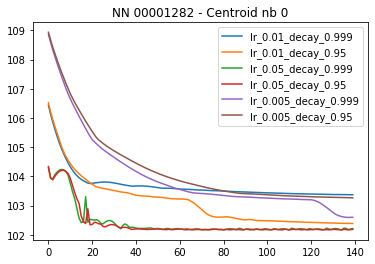

lr : 0.01 Param : [[5.91975098e+01 5.31771088e+00 3.06572632e+02 1.23503805e+05
  3.20516968e+03]]
lr : 0.01 Param : [[5.9521690e+01 5.3024702e+00 3.0961542e+02 1.2402017e+05 3.2491577e+03]]
lr : 0.05 Param : [[6.07807083e+01 5.37758112e+00 3.05663940e+02 1.24514086e+05
  3.26378027e+03]]
lr : 0.05 Param : [[5.5623749e+01 3.7900262e+00 3.1319562e+02 1.2424243e+05 1.2226746e+03]]
lr : 0.005 Param : [[5.9576061e+01 5.2973294e+00 3.1031104e+02 1.2385559e+05 3.1680120e+03]]
lr : 0.005 Param : [[6.44863586e+01 4.51264381e+00 3.15583618e+02 1.21462984e+05
  2.98754492e+03]]


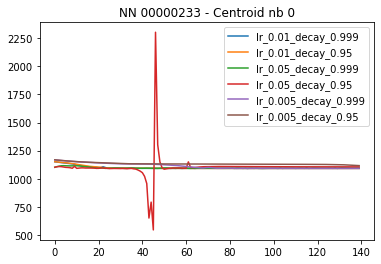

lr : 0.01 Param : [[5.8903763e+01 5.3451805e+00 3.9851862e+02 1.1257342e+05 1.7059351e+03]]
lr : 0.01 Param : [[5.92928619e+01 5.44106722e+00 3.59380646e+02 1.22270195e+05
  2.29672510e+03]]
lr : 0.05 Param : [[6.0020916e+01 5.3724775e+00 3.6387051e+02 1.2065121e+05 2.0422908e+03]]
lr : 0.05 Param : [[5.8887691e+01 5.2309990e+00 4.5194156e+02 1.1028021e+05 1.7213979e+03]]
lr : 0.005 Param : [[5.9351082e+01 5.4411426e+00 3.6901617e+02 1.2221258e+05 2.6772917e+03]]
lr : 0.005 Param : [[5.9108215e+01 5.4342093e+00 3.7745490e+02 1.2253627e+05 2.9822910e+03]]


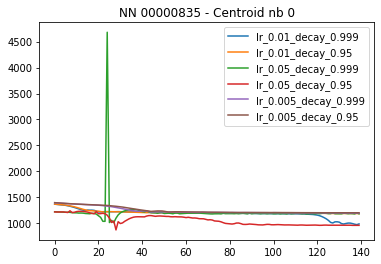

lr : 0.01 Param : [[6.1553181e+01 3.2060490e+00 3.4707590e+02 1.0157029e+05 3.0583542e+03]]
lr : 0.01 Param : [[6.15726471e+01 3.21263504e+00 3.47007111e+02 1.01345125e+05
  3.06327515e+03]]
lr : 0.05 Param : [[6.4904419e+01 3.2333558e+00 3.4341348e+02 1.0275346e+05 3.0714275e+03]]
lr : 0.05 Param : [[6.1566830e+01 3.2144041e+00 3.4697772e+02 1.0133503e+05 3.0547180e+03]]
lr : 0.005 Param : [[6.1556946e+01 3.2075615e+00 3.4703931e+02 1.0153757e+05 3.0618599e+03]]
lr : 0.005 Param : [[6.15376701e+01 3.20596743e+00 3.47121857e+02 1.01636695e+05
  3.07203369e+03]]


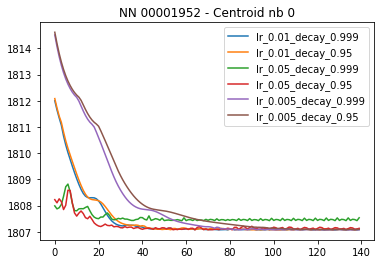

-------------------------
lr : 0.01 Param : [[5.6860535e+01 4.6098337e+00 2.9176312e+02 1.2059706e+05 1.4235544e+03]]
lr : 0.01 Param : [[5.6064999e+01 4.2560563e+00 3.0334250e+02 1.1885598e+05 1.3683888e+03]]
lr : 0.05 Param : [[5.6812077e+01 4.5465221e+00 2.9407214e+02 1.2036097e+05 1.4234713e+03]]
lr : 0.05 Param : [[5.6887215e+01 4.6307936e+00 2.9274701e+02 1.2046566e+05 1.4211892e+03]]
lr : 0.005 Param : [[5.5816746e+01 4.0321674e+00 2.8738342e+02 1.1262319e+05 1.2312130e+03]]
lr : 0.005 Param : [[5.4831837e+01 4.1346312e+00 2.5533905e+02 1.0846117e+05 1.0421252e+03]]


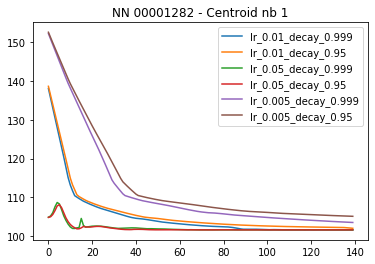

lr : 0.01 Param : [[6.5272087e+01 4.3094106e+00 3.0822150e+02 1.2561926e+05 1.5020219e+03]]
lr : 0.01 Param : [[6.52603683e+01 4.30437899e+00 3.08096313e+02 1.25624695e+05
  1.49888843e+03]]
lr : 0.05 Param : [[6.5228561e+01 4.2837553e+00 3.0856903e+02 1.2560436e+05 1.4900023e+03]]
lr : 0.05 Param : [[6.5171074e+01 4.2834196e+00 3.0826254e+02 1.2562916e+05 1.4865126e+03]]
lr : 0.005 Param : [[6.4966835e+01 4.2664647e+00 3.0756146e+02 1.2538481e+05 1.5023877e+03]]
lr : 0.005 Param : [[5.6532104e+01 3.8858237e+00 3.0414560e+02 1.2427423e+05 1.5060936e+03]]


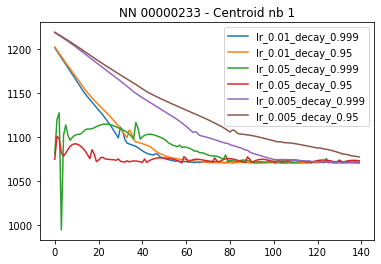

lr : 0.01 Param : [[5.8744881e+01 5.3371024e+00 3.1289053e+02 1.2243406e+05 1.4708005e+03]]
lr : 0.01 Param : [[5.8749500e+01 5.3359885e+00 3.1092609e+02 1.2267583e+05 1.4671676e+03]]
lr : 0.05 Param : [[5.9944153e+01 4.7338986e+00 3.0641821e+02 1.2072567e+05 1.4805139e+03]]
lr : 0.05 Param : [[5.86237831e+01 5.36669016e+00 3.14679749e+02 1.22539234e+05
  1.45191150e+03]]
lr : 0.005 Param : [[5.94474068e+01 5.34303188e+00 3.14139771e+02 1.22273805e+05
  1.46062756e+03]]
lr : 0.005 Param : [[5.4266983e+01 3.4752233e+00 2.8482709e+02 1.2260257e+05 1.5073159e+03]]


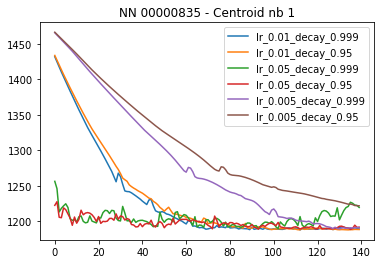

lr : 0.01 Param : [[5.6064907e+01 3.7973776e+00 3.4242206e+02 1.0672325e+05 1.5062726e+03]]
lr : 0.01 Param : [[5.60356102e+01 3.76328564e+00 3.40137207e+02 1.06680945e+05
  1.50757373e+03]]
lr : 0.05 Param : [[5.9549507e+01 4.6622405e+00 3.5870227e+02 1.0369680e+05 1.4862335e+03]]
lr : 0.05 Param : [[5.5998928e+01 3.7755587e+00 3.3945166e+02 1.0668010e+05 1.5091907e+03]]
lr : 0.005 Param : [[5.6160614e+01 3.7797766e+00 3.4034552e+02 1.0668536e+05 1.5095337e+03]]
lr : 0.005 Param : [[5.5487911e+01 3.7747679e+00 3.3996362e+02 1.0676415e+05 1.5095388e+03]]


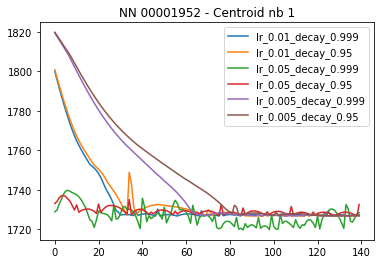

-------------------------
lr : 0.01 Param : [[1.4468602e+02 1.9696697e+01 1.3844421e+03 3.7990400e+05 1.8431035e+03]]
lr : 0.01 Param : [[1.3138884e+02 2.1448391e+01 1.3277493e+03 3.7990400e+05 1.8547892e+03]]
lr : 0.05 Param : [[2.0000000e+02 2.7290695e+01 1.8540131e+03 3.7990400e+05 1.7448721e+03]]
lr : 0.05 Param : [[2.0000000e+02 2.5200609e+01 1.7602256e+03 3.7990400e+05 1.7499944e+03]]
lr : 0.005 Param : [[1.2181888e+02 2.3328197e+01 1.2499501e+03 3.7730578e+05 1.8723805e+03]]
lr : 0.005 Param : [[1.1529724e+02 2.4627964e+01 1.1939443e+03 3.5696975e+05 1.8887526e+03]]


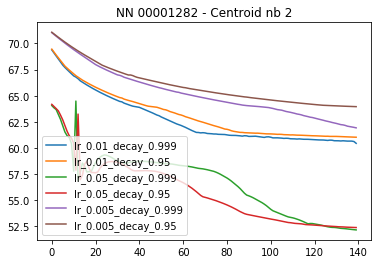

lr : 0.01 Param : [[1.5055447e+02 3.1999998e+01 1.2365145e+03 3.7990400e+05 1.6699655e+03]]
lr : 0.01 Param : [[1.3634167e+02 3.1999998e+01 1.2132687e+03 3.7990400e+05 1.6721108e+03]]
lr : 0.05 Param : [[1.0397702e+02 1.4792186e+01 1.2668065e+03 3.7990400e+05 1.2973391e+03]]
lr : 0.05 Param : [[1.0153698e+02 1.9374962e+01 1.3990287e+03 3.7990400e+05 1.3540481e+03]]
lr : 0.005 Param : [[1.2469175e+02 3.0511501e+01 1.1745037e+03 3.7943519e+05 1.6733545e+03]]
lr : 0.005 Param : [[1.1643438e+02 2.9565668e+01 1.1622905e+03 3.6487912e+05 1.6710504e+03]]


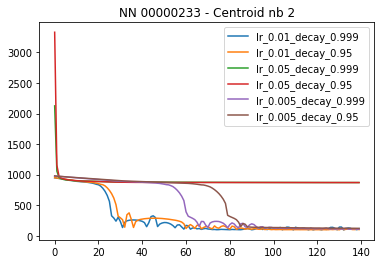

lr : 0.01 Param : [[1.3576950e+02 2.0881651e+01 1.3987031e+03 3.7990400e+05 1.8445400e+03]]
lr : 0.01 Param : [[1.2639078e+02 2.2551250e+01 1.3301995e+03 3.7990400e+05 1.8521752e+03]]
lr : 0.05 Param : [[2.0000000e+02 2.5517996e+01 1.7885135e+03 3.7990400e+05 1.7582439e+03]]
lr : 0.05 Param : [[2.0000000e+02 1.9924387e+01 1.4396096e+03 3.7990400e+05 1.9361310e+03]]
lr : 0.005 Param : [[1.2103494e+02 2.4745150e+01 1.2364490e+03 3.6276347e+05 1.8624901e+03]]
lr : 0.005 Param : [[1.1826033e+02 2.6009418e+01 1.1686732e+03 3.4743688e+05 1.9933772e+03]]


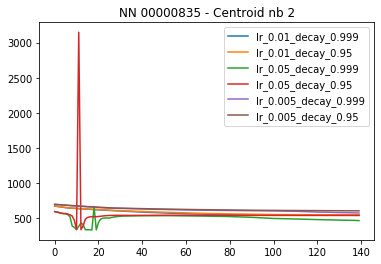

lr : 0.01 Param : [[1.4749692e+02 1.9930923e+01 1.4425654e+03 3.7990400e+05 1.8238068e+03]]
lr : 0.01 Param : [[1.3195219e+02 2.1274958e+01 1.3642607e+03 3.7990400e+05 1.8508207e+03]]
lr : 0.05 Param : [[2.0000000e+02 1.8191994e+01 1.3685217e+03 3.7990400e+05 2.0468666e+03]]
lr : 0.05 Param : [[2.0000000e+02 1.9276031e+01 1.4146478e+03 3.7990400e+05 1.9738439e+03]]
lr : 0.005 Param : [[1.21884796e+02 2.25944347e+01 1.27748718e+03 3.79904000e+05
  1.86294385e+03]]
lr : 0.005 Param : [[1.1652351e+02 2.3727188e+01 1.2114319e+03 3.6326272e+05 1.8761525e+03]]


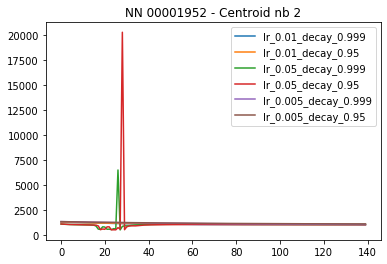

-------------------------
lr : 0.01 Param : [[5.9078739e+01 5.2772808e+00 1.3813309e+03 1.1940049e+05 1.8620867e+03]]
lr : 0.01 Param : [[5.9570202e+01 5.3028836e+00 1.5071624e+03 1.1977494e+05 1.8455369e+03]]
lr : 0.05 Param : [[5.9498386e+01 4.9792705e+00 1.2694050e+03 1.1879610e+05 2.1029675e+03]]
lr : 0.05 Param : [[5.9380024e+01 5.1937280e+00 1.2681969e+03 1.1882796e+05 2.0769221e+03]]
lr : 0.005 Param : [[5.9917233e+01 5.3437619e+00 1.6583176e+03 1.1978123e+05 1.8210571e+03]]
lr : 0.005 Param : [[6.0603813e+01 5.3665080e+00 1.7622595e+03 1.1998078e+05 1.8031982e+03]]


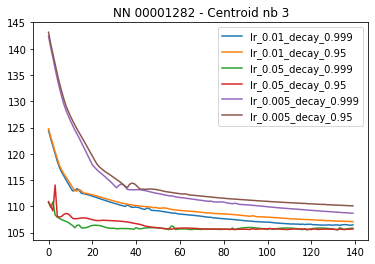

lr : 0.01 Param : [[6.0686363e+01 4.5068622e+00 1.3648636e+03 1.2689718e+05 1.7095288e+03]]
lr : 0.01 Param : [[5.9660717e+01 4.7763491e+00 1.5516384e+03 1.2786670e+05 1.7035393e+03]]
lr : 0.05 Param : [[6.4397308e+01 5.2894211e+00 1.3241600e+03 1.2135127e+05 1.0676798e+03]]
lr : 0.05 Param : [[6.3289925e+01 5.3404117e+00 1.3195327e+03 1.2462524e+05 1.1711716e+03]]
lr : 0.005 Param : [[6.1518150e+01 5.2686825e+00 1.7381713e+03 1.2802295e+05 1.7155232e+03]]
lr : 0.005 Param : [[6.03738022e+01 4.99612713e+00 1.76629712e+03 1.23781695e+05
  1.70162537e+03]]


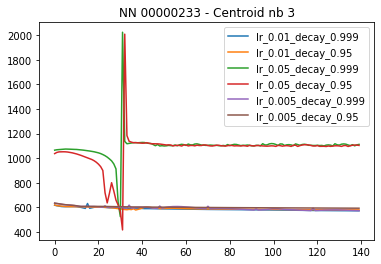

lr : 0.01 Param : [[6.4769653e+01 5.2268233e+00 1.7151542e+03 1.1389148e+05 1.7322546e+03]]
lr : 0.01 Param : [[6.4788902e+01 5.2424808e+00 1.7479104e+03 1.1419920e+05 1.7326027e+03]]
lr : 0.05 Param : [[5.9346638e+01 5.3972259e+00 1.8725652e+03 1.1559128e+05 1.7728865e+03]]
lr : 0.05 Param : [[5.7219788e+01 5.3718100e+00 1.5813817e+03 1.2061486e+05 1.8552842e+03]]
lr : 0.005 Param : [[6.7455544e+01 3.5028448e+00 1.7416149e+03 1.1241841e+05 1.6776024e+03]]
lr : 0.005 Param : [[6.7398354e+01 3.6628914e+00 1.8249596e+03 1.1174321e+05 1.6795397e+03]]


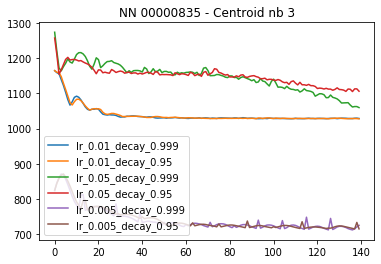

lr : 0.01 Param : [[6.70014648e+01 2.60365939e+00 1.54747534e+03 1.00792055e+05
  1.67921204e+03]]
lr : 0.01 Param : [[6.7139359e+01 2.7478697e+00 1.6773829e+03 1.0197850e+05 1.6841609e+03]]
lr : 0.05 Param : [[5.8669369e+01 4.7345061e+00 1.3491626e+03 1.0248697e+05 2.0422277e+03]]
lr : 0.05 Param : [[5.9576660e+01 4.6565571e+00 1.3912855e+03 1.0248138e+05 2.0231963e+03]]
lr : 0.005 Param : [[6.7005745e+01 2.9669271e+00 1.7168995e+03 1.0294484e+05 1.6843915e+03]]
lr : 0.005 Param : [[6.6961418e+01 3.2607322e+00 1.8079534e+03 1.0482242e+05 1.6835511e+03]]


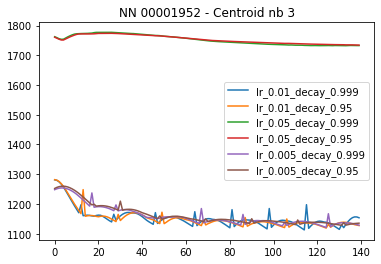

-------------------------
lr : 0.01 Param : [[6.2428669e+01 1.3681633e+01 1.2898993e+03 3.7990400e+05 1.9020656e+03]]
lr : 0.01 Param : [[6.2521297e+01 1.1959440e+01 1.2732625e+03 3.7990400e+05 1.9134854e+03]]
lr : 0.05 Param : [[5.6396564e+01 1.9734531e+01 1.3503008e+03 3.7990400e+05 1.8806279e+03]]
lr : 0.05 Param : [[5.7143429e+01 1.9580034e+01 1.3507582e+03 3.7990400e+05 1.8836234e+03]]
lr : 0.005 Param : [[6.2283459e+01 1.0660809e+01 1.2353625e+03 3.7990400e+05 1.9313807e+03]]
lr : 0.005 Param : [[6.3329723e+01 9.4914827e+00 1.1969070e+03 3.7990400e+05 1.9486710e+03]]


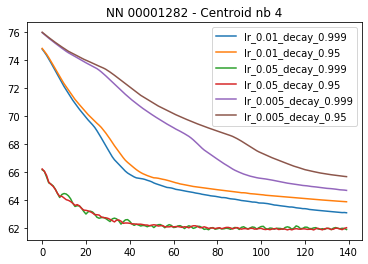

lr : 0.01 Param : [[6.7567413e+01 1.0085531e+01 1.2916559e+03 3.7990400e+05 1.6691875e+03]]
lr : 0.01 Param : [[6.7094391e+01 9.0962887e+00 1.2426757e+03 3.7990400e+05 1.6699769e+03]]
lr : 0.05 Param : [[4.6971481e+01 2.3404842e+01 1.1777803e+03 3.7990400e+05 2.2667773e+03]]
lr : 0.05 Param : [[6.0881229e+01 1.6114719e+01 1.4296494e+03 3.5857969e+05 1.3606371e+03]]
lr : 0.005 Param : [[6.7264351e+01 8.7924271e+00 1.1855605e+03 3.7990400e+05 1.6728322e+03]]
lr : 0.005 Param : [[6.5956985e+01 8.1764450e+00 1.1565874e+03 3.7990400e+05 1.6709695e+03]]


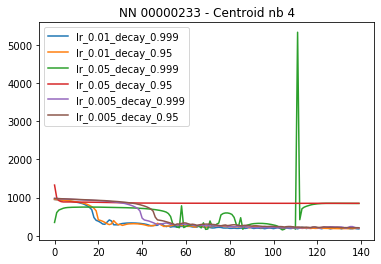

lr : 0.01 Param : [[6.2500038e+01 6.1743903e+00 1.1865999e+03 3.7990400e+05 2.1777922e+03]]
lr : 0.01 Param : [[6.2849453e+01 6.1799541e+00 1.1751501e+03 3.7823638e+05 2.2002407e+03]]
lr : 0.05 Param : [[4.8394493e+01 7.2037840e+00 1.3757874e+03 3.7990400e+05 1.9323953e+03]]
lr : 0.05 Param : [[6.1799427e+01 6.2117872e+00 1.2039470e+03 3.7990400e+05 2.1429897e+03]]
lr : 0.005 Param : [[6.3476555e+01 6.1777906e+00 1.1465359e+03 3.7493044e+05 2.2163882e+03]]
lr : 0.005 Param : [[6.0965427e+01 6.1932564e+00 1.1242814e+03 3.6802891e+05 2.2446536e+03]]


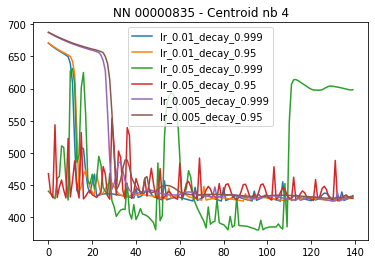

lr : 0.01 Param : [[6.3190258e+01 7.8006306e+00 1.4240686e+03 3.7990400e+05 1.6936377e+03]]
lr : 0.01 Param : [[4.9318211e+01 6.6943097e+00 1.3443933e+03 3.7990400e+05 1.9595741e+03]]
lr : 0.05 Param : [[1.00191315e+02 8.54127502e+00 1.41700586e+03 3.79904000e+05
  2.15122729e+03]]
lr : 0.05 Param : [[5.0962013e+01 6.7391930e+00 1.4398958e+03 3.7990400e+05 1.9389229e+03]]
lr : 0.005 Param : [[4.9981510e+01 6.6795063e+00 1.2671077e+03 3.7990400e+05 2.0164932e+03]]
lr : 0.005 Param : [[5.0215740e+01 6.6907792e+00 1.2114882e+03 3.7990400e+05 2.0335183e+03]]


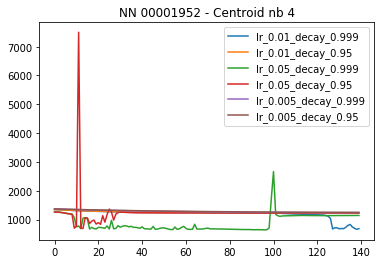

-------------------------
lr : 0.01 Param : [[1.98386993e+02 4.87482071e+00 1.34954028e+03 1.20742664e+05
  3.01807300e+03]]
lr : 0.01 Param : [[1.88432907e+02 5.09767389e+00 1.35323303e+03 1.20744875e+05
  2.88002051e+03]]
lr : 0.05 Param : [[2.00000000e+02 4.94988346e+00 1.34654443e+03 1.20754086e+05
  3.09803687e+03]]
lr : 0.05 Param : [[2.0000000e+02 4.9130163e+00 1.3452692e+03 1.2072828e+05 3.0904736e+03]]
lr : 0.005 Param : [[1.83060669e+02 5.13850784e+00 1.40064026e+03 1.20772266e+05
  2.66523877e+03]]
lr : 0.005 Param : [[1.8164156e+02 4.9778280e+00 1.4333484e+03 1.1994617e+05 2.6618015e+03]]


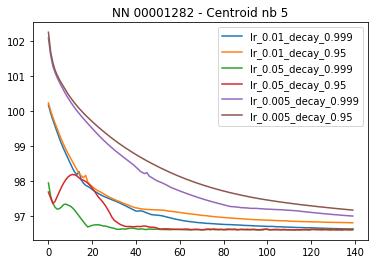

lr : 0.01 Param : [[1.0805751e+02 5.0387721e+00 1.3678157e+03 1.1738803e+05 3.3294426e+03]]
lr : 0.01 Param : [[1.15239471e+02 4.99871254e+00 1.39959265e+03 1.17848234e+05
  3.40949951e+03]]
lr : 0.05 Param : [[9.1309219e+01 5.2346997e+00 1.4228102e+03 1.1822316e+05 3.8537844e+03]]
lr : 0.05 Param : [[8.8594414e+01 5.1701012e+00 1.4278240e+03 1.1718826e+05 3.9383967e+03]]
lr : 0.005 Param : [[1.2646410e+02 5.0083151e+00 1.4130996e+03 1.1860978e+05 3.4351790e+03]]
lr : 0.005 Param : [[1.34841095e+02 5.00020361e+00 1.44632422e+03 1.18516414e+05
  3.41110767e+03]]


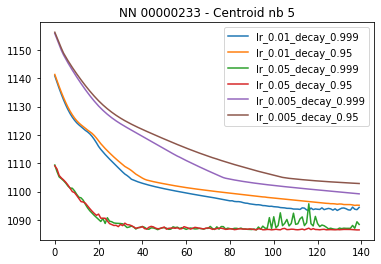

lr : 0.01 Param : [[1.30496506e+02 5.17159748e+00 1.79393445e+03 1.14126445e+05
  1.73001855e+03]]
lr : 0.01 Param : [[1.4172374e+02 5.1853056e+00 1.5907733e+03 1.1255254e+05 1.7252845e+03]]
lr : 0.05 Param : [[1.1433027e+02 5.1162310e+00 1.8731117e+03 1.1352869e+05 1.7356263e+03]]
lr : 0.05 Param : [[1.08417702e+02 5.19332647e+00 1.89453455e+03 1.13641586e+05
  1.73692151e+03]]
lr : 0.005 Param : [[1.42247223e+02 5.48696136e+00 1.54201807e+03 1.17038305e+05
  2.04123401e+03]]
lr : 0.005 Param : [[1.4830399e+02 5.4756036e+00 1.5582889e+03 1.1608799e+05 2.3589663e+03]]


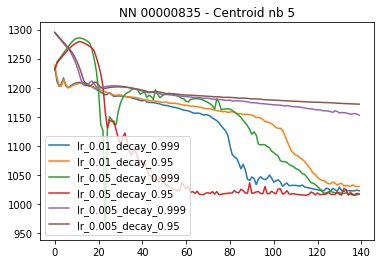

lr : 0.01 Param : [[1.20791168e+02 4.95427227e+00 1.42471741e+03 1.06698445e+05
  3.15942432e+03]]
lr : 0.01 Param : [[1.2678334e+02 4.9584198e+00 1.4445425e+03 1.0691175e+05 3.2131470e+03]]
lr : 0.05 Param : [[1.0733521e+02 5.0986547e+00 1.4397896e+03 1.0760844e+05 3.1914138e+03]]
lr : 0.05 Param : [[1.0614541e+02 5.0887012e+00 1.4436703e+03 1.0719785e+05 3.1484292e+03]]
lr : 0.005 Param : [[1.29376724e+02 4.96098471e+00 1.43232983e+03 1.06803086e+05
  3.27635352e+03]]
lr : 0.005 Param : [[1.3782848e+02 4.9856415e+00 1.4544596e+03 1.0696624e+05 3.3285740e+03]]


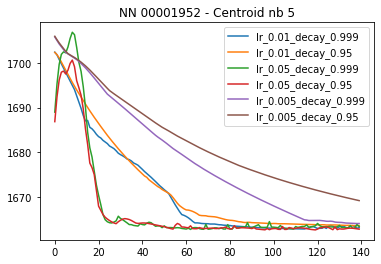

-------------------------
lr : 0.01 Param : [[7.7243881e+01 1.9935976e+01 1.2262406e+03 1.1942813e+05 2.2944897e+03]]
lr : 0.01 Param : [[7.7077599e+01 2.0579031e+01 1.2192037e+03 1.1952359e+05 2.2625107e+03]]
lr : 0.05 Param : [[1.62587082e+02 2.12642231e+01 1.39242834e+03 1.23593805e+05
  1.93601208e+03]]
lr : 0.05 Param : [[1.54345886e+02 1.92024899e+01 1.37773132e+03 1.20972195e+05
  2.16372217e+03]]
lr : 0.005 Param : [[7.7195511e+01 2.1043974e+01 1.1935496e+03 1.1966160e+05 2.2190232e+03]]
lr : 0.005 Param : [[7.70053711e+01 2.25512466e+01 1.15443982e+03 1.19674195e+05
  2.18553003e+03]]


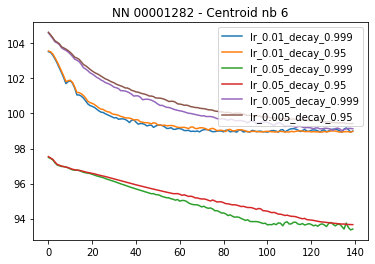

lr : 0.01 Param : [[9.4435577e+01 2.9662615e+01 1.2548601e+03 1.2933702e+05 1.6680480e+03]]
lr : 0.01 Param : [[9.0085670e+01 2.7846588e+01 1.2128884e+03 1.2716233e+05 1.7013940e+03]]
lr : 0.05 Param : [[8.9849602e+01 2.5902851e+01 1.3655360e+03 1.2112173e+05 1.2228280e+03]]
lr : 0.05 Param : [[8.5352776e+01 2.7780197e+01 9.9984552e+02 1.3107088e+05 1.3736301e+03]]
lr : 0.005 Param : [[8.1622337e+01 3.0675411e+01 1.1181129e+03 1.2783341e+05 1.6658386e+03]]
lr : 0.005 Param : [[8.1487968e+01 2.9184515e+01 1.0892643e+03 1.2765041e+05 1.6653597e+03]]


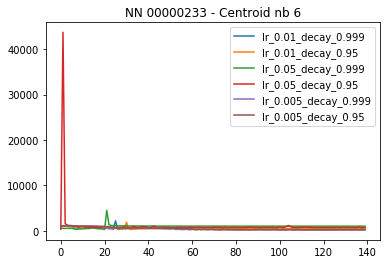

lr : 0.01 Param : [[7.7252907e+01 2.0960199e+01 1.3070166e+03 1.1983537e+05 1.9306166e+03]]
lr : 0.01 Param : [[7.7241318e+01 2.1802528e+01 1.2695342e+03 1.1964365e+05 1.9225941e+03]]
lr : 0.05 Param : [[1.62789154e+02 2.09250221e+01 1.61898950e+03 1.18282266e+05
  1.85769470e+03]]
lr : 0.05 Param : [[1.7733644e+02 3.1999998e+01 1.7674435e+03 1.1871533e+05 1.6843687e+03]]
lr : 0.005 Param : [[7.7170372e+01 2.2845175e+01 1.2102393e+03 1.1914140e+05 1.9178082e+03]]
lr : 0.005 Param : [[7.7029854e+01 2.3622429e+01 1.1585863e+03 1.1897781e+05 1.9104828e+03]]


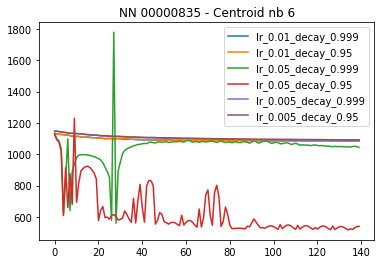

lr : 0.01 Param : [[7.7217140e+01 1.6187799e+01 1.3273126e+03 1.0702100e+05 2.0390425e+03]]
lr : 0.01 Param : [[7.72094650e+01 1.86905308e+01 1.27688953e+03 1.07959516e+05
  2.04589502e+03]]
lr : 0.05 Param : [[1.1830989e+02 1.7013878e+01 1.4021254e+03 1.0736146e+05 2.8191375e+03]]
lr : 0.05 Param : [[1.1439199e+02 1.7006372e+01 1.4033557e+03 1.0724643e+05 2.8070825e+03]]
lr : 0.005 Param : [[7.7144234e+01 2.0718563e+01 1.2074191e+03 1.0943565e+05 2.0574070e+03]]
lr : 0.005 Param : [[7.7018036e+01 2.2257870e+01 1.1577234e+03 1.1023549e+05 2.0630730e+03]]


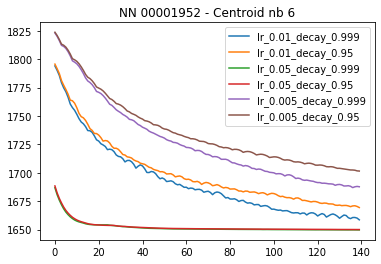

-------------------------
lr : 0.01 Param : [[5.3433018e+01 4.1081505e+00 3.1213443e+02 2.8034206e+05 1.4835564e+03]]
lr : 0.01 Param : [[5.4081524e+01 4.1920075e+00 3.1393680e+02 2.5319398e+05 1.4849005e+03]]
lr : 0.05 Param : [[5.5963348e+01 3.9028120e+00 3.2022659e+02 3.7990400e+05 1.4618811e+03]]
lr : 0.05 Param : [[5.6025860e+01 3.9075286e+00 3.2303409e+02 3.7990400e+05 1.4653564e+03]]
lr : 0.005 Param : [[5.4306007e+01 4.2512789e+00 3.1717459e+02 2.3316627e+05 1.4901622e+03]]
lr : 0.005 Param : [[5.5377792e+01 4.4500442e+00 3.0457761e+02 2.1977973e+05 1.4889900e+03]]


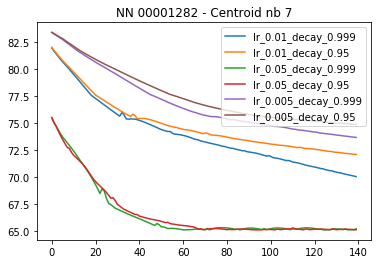

lr : 0.01 Param : [[5.6258423e+01 4.2282763e+00 3.4052692e+02 2.6827119e+05 1.4840228e+03]]
lr : 0.01 Param : [[5.6216194e+01 4.2316427e+00 3.4019489e+02 2.4757636e+05 1.4882474e+03]]
lr : 0.05 Param : [[6.1744431e+01 4.0057635e+00 3.3312167e+02 3.7990400e+05 1.4565309e+03]]
lr : 0.05 Param : [[6.1150513e+01 3.9385707e+00 3.4220859e+02 3.7990400e+05 1.4591093e+03]]
lr : 0.005 Param : [[5.6642746e+01 4.2724271e+00 3.4728049e+02 2.3101659e+05 1.4886027e+03]]
lr : 0.005 Param : [[5.8736019e+01 4.4542794e+00 3.4002542e+02 2.1875281e+05 1.4898707e+03]]


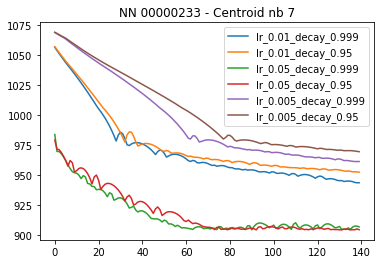

lr : 0.01 Param : [[5.8552273e+01 4.8208332e+00 3.6027170e+02 2.8985612e+05 1.4689585e+03]]
lr : 0.01 Param : [[5.6234619e+01 5.0181260e+00 3.5460019e+02 2.6067583e+05 1.4676819e+03]]
lr : 0.05 Param : [[5.9934944e+01 3.4263663e+00 3.2609763e+02 3.7990400e+05 1.4702115e+03]]
lr : 0.05 Param : [[5.9870995e+01 3.4164488e+00 3.2568051e+02 3.7990400e+05 1.4686407e+03]]
lr : 0.005 Param : [[5.7014633e+01 4.8774905e+00 3.5791589e+02 2.3905914e+05 1.4765363e+03]]
lr : 0.005 Param : [[5.7421406e+01 4.7329769e+00 3.7512473e+02 2.2310450e+05 1.4861094e+03]]


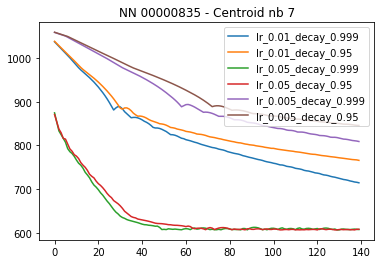

lr : 0.01 Param : [[6.2277309e+01 5.0951886e+00 3.6002744e+02 2.8942228e+05 1.4589535e+03]]
lr : 0.01 Param : [[5.9525501e+01 5.0456610e+00 3.5391891e+02 2.6368141e+05 1.4657047e+03]]
lr : 0.05 Param : [[5.8097115e+01 3.2608104e+00 3.2781757e+02 3.7990400e+05 1.4726902e+03]]
lr : 0.05 Param : [[5.7919971e+01 3.2380033e+00 3.2730893e+02 3.7990400e+05 1.4691722e+03]]
lr : 0.005 Param : [[5.9736794e+01 4.9000654e+00 3.5050128e+02 2.4001925e+05 1.4721633e+03]]
lr : 0.005 Param : [[6.0087112e+01 4.7585664e+00 3.5312228e+02 2.2274225e+05 1.4826385e+03]]


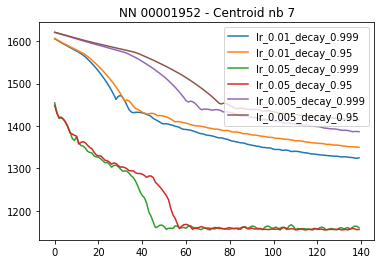

-------------------------
lr : 0.01 Param : [[1.9149118e+02 6.2999992e+00 1.1879971e+03 3.7990400e+05 1.7218403e+03]]
lr : 0.01 Param : [[1.8483963e+02 6.3318710e+00 1.1354564e+03 3.7990400e+05 1.7069647e+03]]
lr : 0.05 Param : [[2.0000000e+02 6.2609487e+00 1.5725782e+03 3.7990400e+05 1.7479702e+03]]
lr : 0.05 Param : [[2.0000000e+02 6.2780137e+00 1.2957627e+03 3.7990400e+05 1.9629606e+03]]
lr : 0.005 Param : [[1.7976875e+02 6.3088732e+00 1.0703303e+03 3.7094834e+05 1.7120262e+03]]
lr : 0.005 Param : [[1.7502922e+02 6.3221493e+00 1.0290250e+03 3.5430428e+05 1.7044152e+03]]


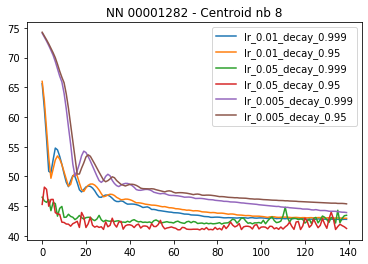

lr : 0.01 Param : [[1.2827916e+02 8.6171169e+00 1.1229142e+03 3.7990400e+05 1.6703983e+03]]
lr : 0.01 Param : [[1.3959956e+02 7.6007438e+00 1.0807693e+03 3.7990400e+05 1.6778041e+03]]
lr : 0.05 Param : [[2.0000000e+02 6.2224483e+00 1.2595094e+03 3.7990400e+05 1.3104398e+03]]
lr : 0.05 Param : [[2.0000000e+02 7.1333055e+00 1.3212037e+03 3.7990400e+05 1.3311492e+03]]
lr : 0.005 Param : [[1.47069748e+02 7.49575710e+00 1.02389594e+03 3.68701500e+05
  1.67872888e+03]]
lr : 0.005 Param : [[1.5436896e+02 7.3715425e+00 9.9533667e+02 3.5161781e+05 1.6785663e+03]]


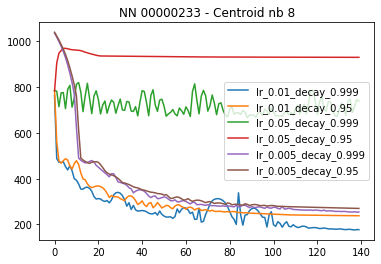

lr : 0.01 Param : [[1.2104890e+02 6.6270962e+00 1.1141079e+03 3.6193419e+05 1.6881030e+03]]
lr : 0.01 Param : [[1.3217062e+02 6.5343604e+00 1.0899551e+03 3.5898503e+05 1.6916245e+03]]
lr : 0.05 Param : [[2.0000000e+02 6.3652787e+00 1.6151035e+03 3.7990400e+05 1.8689281e+03]]
lr : 0.05 Param : [[2.0000000e+02 6.2893639e+00 1.5017057e+03 3.7990400e+05 1.8205404e+03]]
lr : 0.005 Param : [[1.3805659e+02 6.4891272e+00 1.0432729e+03 3.5204019e+05 1.6945581e+03]]
lr : 0.005 Param : [[1.4754080e+02 6.4925766e+00 1.0187842e+03 3.4545288e+05 1.6947179e+03]]


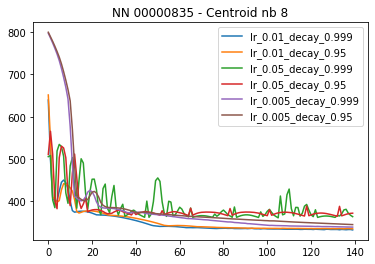

lr : 0.01 Param : [[2.0000000e+02 1.4210419e+01 1.1901605e+03 3.7990400e+05 1.6971779e+03]]
lr : 0.01 Param : [[2.0000000e+02 1.2521029e+01 1.1287836e+03 3.7990400e+05 1.6905582e+03]]
lr : 0.05 Param : [[2.0000000e+02 3.1999998e+01 1.7604573e+03 3.7990400e+05 1.6957290e+03]]
lr : 0.05 Param : [[2.0000000e+02 2.8231735e+01 1.6559077e+03 3.7990400e+05 1.6860293e+03]]
lr : 0.005 Param : [[1.5640125e+02 6.4847579e+00 1.0488436e+03 3.5577600e+05 1.6942202e+03]]
lr : 0.005 Param : [[1.6643004e+02 6.7566051e+00 1.0134342e+03 3.4366241e+05 1.6990895e+03]]


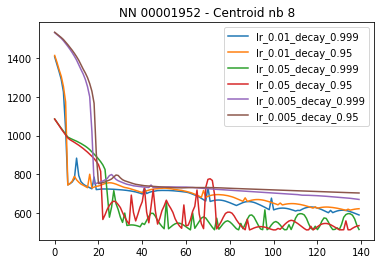

-------------------------
lr : 0.01 Param : [[1.9115773e+02 4.9026833e+00 3.1284442e+02 1.1808861e+05 1.4668606e+03]]
lr : 0.01 Param : [[1.8587199e+02 4.9428592e+00 3.0284781e+02 1.1810025e+05 1.4684907e+03]]
lr : 0.05 Param : [[1.8924153e+02 4.7399192e+00 3.0239636e+02 1.1801546e+05 1.4671418e+03]]
lr : 0.05 Param : [[1.9105743e+02 4.8302779e+00 3.1045926e+02 1.1807697e+05 1.4671184e+03]]
lr : 0.005 Param : [[1.7794395e+02 4.8901215e+00 3.1284457e+02 1.1736556e+05 1.4635089e+03]]
lr : 0.005 Param : [[1.68125290e+02 4.78092289e+00 3.28959198e+02 1.14270164e+05
  1.47052002e+03]]


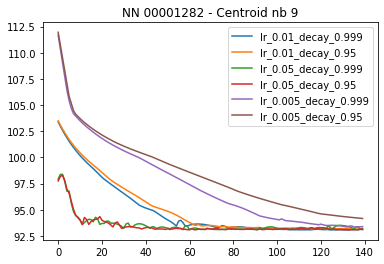

lr : 0.01 Param : [[1.3160767e+02 4.4792805e+00 3.1807556e+02 1.2352575e+05 1.4884021e+03]]
lr : 0.01 Param : [[1.31913437e+02 4.48467302e+00 3.15848785e+02 1.23512266e+05
  1.48914221e+03]]
lr : 0.05 Param : [[1.30017303e+02 4.43448496e+00 3.18444641e+02 1.23646555e+05
  1.48025195e+03]]
lr : 0.05 Param : [[1.3162874e+02 4.4699206e+00 3.1786716e+02 1.2325969e+05 1.4855820e+03]]
lr : 0.005 Param : [[1.3721225e+02 4.4921131e+00 3.1842780e+02 1.2310162e+05 1.4889808e+03]]
lr : 0.005 Param : [[1.4514658e+02 4.5038204e+00 3.3057153e+02 1.2218703e+05 1.4873292e+03]]


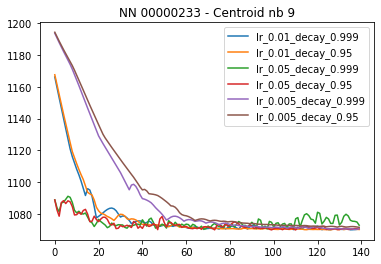

lr : 0.01 Param : [[1.7650136e+02 5.4325738e+00 4.5026831e+02 1.1982690e+05 1.4252438e+03]]
lr : 0.01 Param : [[1.7522025e+02 5.4370217e+00 4.5237997e+02 1.1966270e+05 1.4147751e+03]]
lr : 0.05 Param : [[1.5427617e+02 5.1936302e+00 3.4595367e+02 1.2144895e+05 1.4610574e+03]]
lr : 0.05 Param : [[1.5039024e+02 5.1567283e+00 3.6145419e+02 1.2145616e+05 1.4696392e+03]]
lr : 0.005 Param : [[1.7359113e+02 5.4234891e+00 4.4537183e+02 1.2005723e+05 1.3947753e+03]]
lr : 0.005 Param : [[1.6691400e+02 5.4335346e+00 4.3935806e+02 1.2034099e+05 1.3886274e+03]]


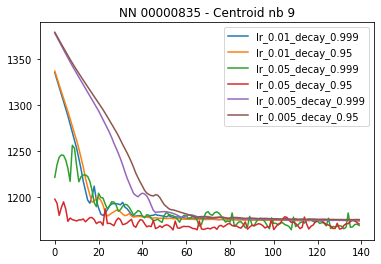

lr : 0.01 Param : [[1.5428526e+02 4.6802492e+00 3.5953079e+02 1.0408397e+05 1.4847396e+03]]
lr : 0.01 Param : [[1.5437308e+02 4.6721687e+00 3.6026248e+02 1.0401009e+05 1.4816029e+03]]
lr : 0.05 Param : [[1.5588072e+02 4.7010765e+00 3.6079816e+02 1.0432785e+05 1.4882719e+03]]
lr : 0.05 Param : [[1.5479921e+02 4.7517233e+00 3.6113065e+02 1.0394066e+05 1.4900448e+03]]
lr : 0.005 Param : [[1.5426668e+02 4.6896505e+00 3.5966580e+02 1.0403324e+05 1.4869124e+03]]
lr : 0.005 Param : [[1.5406216e+02 4.6860237e+00 3.6203574e+02 1.0426443e+05 1.4852976e+03]]


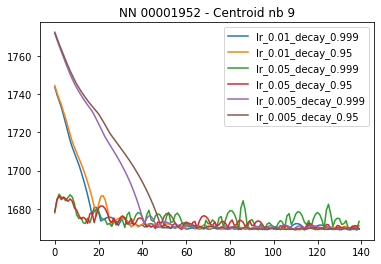

-------------------------


In [93]:
%pycache
#real_power = 105.9412083326798
real_power = 0.1
power_to_have =real_power

learning_rate=0.1

random_networks = random.sample(val_network_names,4)

#index=randrange(nb_val)

for i in range(10):
    for name in random_networks:
        NN_list = list(copy.deepcopy(nets_dict[name]))
        NN_param = TreatNeuralNetwork_searchphase(NN_list,std).NN_to_input().numpy()
        NN_param = NN_param.reshape((1,37,7))  

        HW_param_norm = centroids_not_reduced[i].reshape((1,5))
        for learning_rate in [0.01, 0.05, 0.005]:
        #for learning_rate in [0.5,0.2]:
            for decay in [0.999, 0.95]:
                lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=learning_rate,
                    decay_steps=10,
                    decay_rate=decay)
                perf_by_power = {}
                #full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=[loss_1])

                full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=[tf.keras.losses.MeanAbsoluteError()],metrics=[loss])
                full_model.layers[recover_index].set_weights(HW_param_norm)
                reverse = full_model.fit(  (NN_param,HW_param_norm) , np.array(power_to_have).reshape(1,1), epochs=150, verbose=0 )

                hw_param_found =full_model.layers[recover_index].get_weights()[0].reshape((1,nb_hw_param))
                full_model.layers[recover_index].set_weights(hw_param_found)
                
                prediction = full_model.predict((NN_param,hw_param_found))
                hw_param= scaler.inverse_transform(hw_param_found)
                performance = loss_1(power_to_have,float(prediction)).numpy()
                perf_by_power[power_to_have]= {"perfs":performance, "hw_params":hw_param, "predictions":float(prediction)}
                plt.plot(reverse.history["loss_1"][10:], label=f"lr_{learning_rate}_decay_{decay}")
                plt.legend()
                plt.title(f"NN {name} - Centroid nb {i}")
                print(f"lr : {learning_rate} Param : {hw_param}")
        plt.show()
    print("-------------------------")


## Model predictions : don't take HW inputs into account (need to set the weights to make a prediction)

In [49]:
full_model.layers[recover_index].set_weights(HW_param_norm)
full_model.predict((NN_param,HW_param_norm))

array([[35.247498]], dtype=float32)

#### Only with zeros

In [50]:
full_model.layers[recover_index].set_weights(np.zeros((HW_param_norm.shape)))
full_model.predict((NN_param,np.zeros((HW_param_norm.shape))))

array([[nan]], dtype=float32)

## Search HW optimum/decreasing POWERS - All networks

In [52]:
%pycache
val_network_names = list(val_hw["name"].unique())
powers_to_have = [0.01]
learning_rate=0.01
decay =0.999
path = "/data_predictor"


six = ['00000006']

for NN_index, array_name in enumerate(val_network_names): # VALIDATION NETWORKS
#for NN_index, array_name in enumerate(six): 
   # try:
    #    os.mkdir(path)
    #except Exception as err:
     #   print("directory exists")    
        
    for power_to_have in powers_to_have: 
        # NN ARRAYS
        NN_list = list(copy.deepcopy(nets_dict[array_name]))
        NN_array = TreatNeuralNetwork_searchphase(NN_list,std).NN_to_input().numpy()
        NN_array = NN_array.reshape((1,37,7))
        
        inputs = (NN_array,HW_initial_params)
        perf_by_power = {}
        
        for centroid_index, HW_initial_params in enumerate(list(centroids_not_reduced)): # CLUSTERS
            HW_initial_params = HW_initial_params.reshape((1,5))
            
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=learning_rate,
                decay_steps=10,
                decay_rate=decay)
            full_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=[tf.keras.losses.MeanAbsoluteError()],metrics=[loss_1])
            full_model.layers[recover_index].set_weights(HW_initial_params)
            reverse = full_model.fit(  (NN_array,HW_initial_params) , np.array(power_to_have).reshape(1,1), epochs=150, verbose =0 )

            hw_param_found =full_model.layers[recover_index].get_weights()[0].reshape((1,nb_hw_param))
            full_model.layers[recover_index].set_weights(hw_param_found)
            prediction = full_model.predict((NN_array,hw_param_found))
            hw_param= scaler.inverse_transform(hw_param_found)

            plt.figure()
            plt.plot(reverse.history["loss_1"])
            plt.title('loss')
            plt.ylabel('loss')
            plt.xlabel('epochs')
            plt.legend([f'train power : {power_to_have}'], loc='upper left')
            
            plt.show()
            performance = loss_1(power_to_have,float(prediction)).numpy()
            perf_by_power[centroid_index]= {"relative error":performance, "hw_params":hw_param, "predictions":float(prediction)}
        
        perfs = pd.DataFrame.from_dict({k : perf_by_power[k] for k in sorted(perf_by_power)})
        perfs.columns.name = f"NN {array_name} - Power {power_to_have}"
        perfs.to_csv(f"{path}/regressions_all_val_networks/{array_name}")
        display(HTML(perfs.to_html()))




UsageError: Line magic function `%pycache` not found.


# 8) More tests

### Evaluate multiple power output

In [ ]:
#val_c = np.concatenate((y_val_bw,y_val_core), axis=1)

if output_shape == 2:

    full_model_mult.compile(optimizer=optimizer, loss=[loss])
    def updateTargetModel(model, targetModel):
      modelWeights       = model.trainable_weights
      targetModelWeights = targetModel.trainable_weights

      for i in range(len(targetModelWeights)):
        targetModelWeights[i].assign(modelWeights[i])
    updateTargetModel(full_model, full_model_mult)

    full_model_mult.evaluate((X_val_nn_norm, X_val_hw_param_norm), y_val_core)

## TEST MODELS RANDOMLY

In [53]:
%pycache
high_powers= [128,256,512,1024]
low_power = [16,32,64]
depths = [1,2,3,4,5,6]
begining 

def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

for ind,power in enumerate(powers):
    for depth in depths[:len(depths)-ind]:
        model_nn = tf.keras.Sequential()
        model_nn.add(layers.Conv1D(power, (3), activation='relu', padding="same",input_shape=(max_blocks, nb_param)))
        for i in range(depth):
            model_nn.add(layers.Conv1D(power, (3), activation='relu', padding="same"))
        model_nn.add(layers.Lambda( lambda x: K.sum(x, axis=1)))
        
        model_hw = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(nb_hw_param,)),
        layers.Dense(power, activation='linear')
        ])

        concat = tf.keras.layers.multiply([model_nn.output, model_hw.output])
        output = tf.keras.layers.Dense(units=16, activation='relu')(concat)
        output = tf.keras.layers.Dense(units=1, activation='relu')(output)
        full_model = tf.keras.Model(inputs=[model_nn.input, model_hw.input], outputs=[output])
       
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=nb_training_batches,
        decay_rate=0.95)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        
        full_epochs = 100

        print(f'PARAMS : {full_model.count_params()}')
        t4= time.clock()
        full_model.compile(optimizer=optimizer, loss=loss)
        history = full_model.fit(train_dataset_norm,
                validation_data=(test_dataset_norm),
                epochs=full_epochs,
                verbose=1, )
        t5= time.clock()
        print(f'Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')
        t5= time.clock()
        nb_final_epochs_for_mean = 5
        print(f'PARAMS : {full_model.count_params()}')
        name = f'power_{power}_depth_{depth}_{full_model.count_params()}_param'
        print(nb_repeat)
        print()
        
        save = True
        nb_predictions = 100
        max_val_loss=0.7
        model = full_model
        X_val_list = [X_val_nn_norm, X_val_hw_param_norm]
        save_model(path=path_entire_model, model= model, history=history, X_list=X_val_list, y=y_val, std=std, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)






UsageError: Line magic function `%pycache` not found.


### Test size dataset - More data?

PARAMS : 117729

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
18/18 [==============================] - ETA: 0s - loss: 0.7482WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1a399ae730> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
C

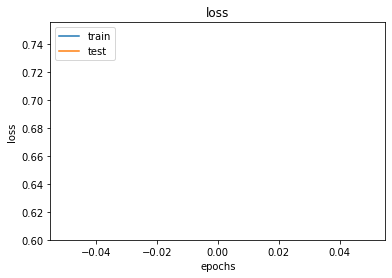

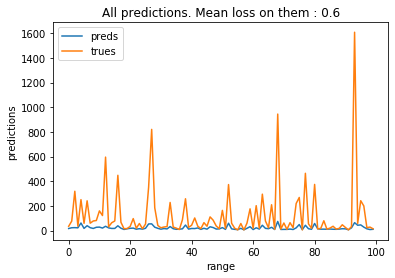

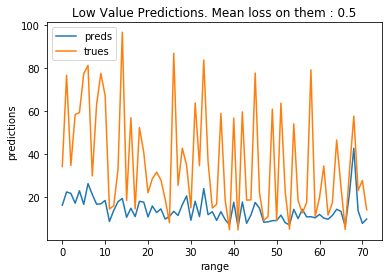

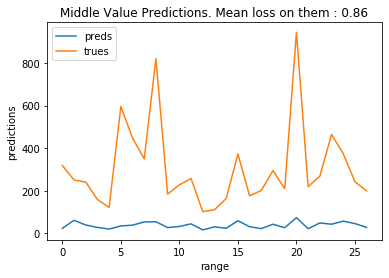

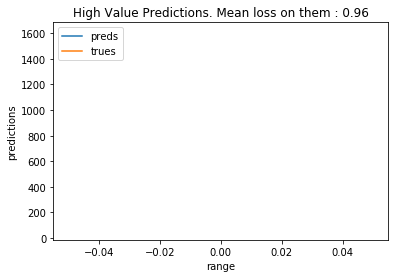

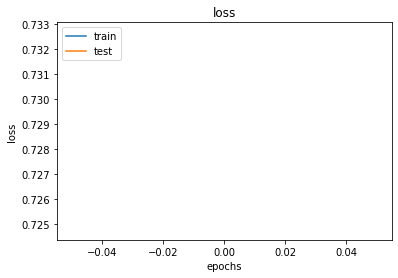

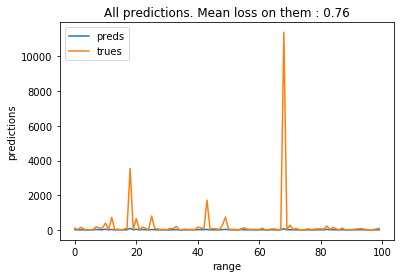

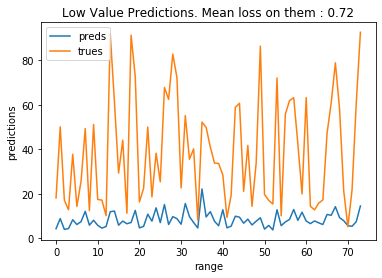

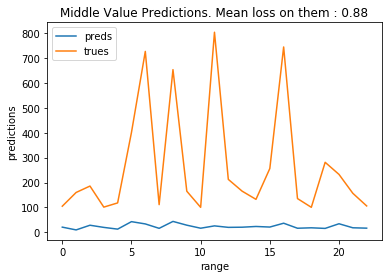

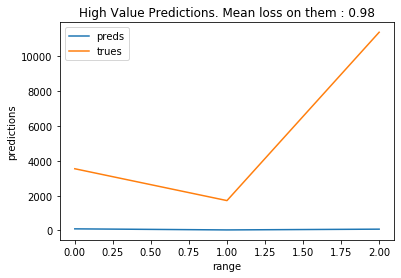

In [58]:

#%pycache
path_test_dataset = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/size_dataset/test_size_dataset_4"

print(f'PARAMS : {full_model.count_params()}')
nb_final_epochs_for_mean = 5
save = True
nb_predictions = 100
max_val_loss=50
X_val_list = [X_val_nn_norm, X_val_hw_param_norm]


full_epochs = 1
test_performances = {}
#percents = [0.97]
percents = [0.25, 0.50, 0.75, 0.85, 0.90, 1]
#percents = [0.25, 0.50]
mini_batches_list = l = [int(x * nb_training_batches) for x in percents]

for i, mini_batches in enumerate(mini_batches_list):
    print()
    full_model.set_weights(Wsave)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    train_dataset_percent_norm =train_dataset_norm.take(mini_batches)
    t4= time.clock()
    full_model.compile(optimizer=optimizer, loss=loss)
    
    history = full_model.fit(train_dataset_percent_norm,
            validation_data=(test_dataset_norm),
            epochs=full_epochs,
            verbose=1,
    )

    t5= time.clock()
    print(f'Mini_batch percent: {percents[i]} Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')
    name = f'percent_{percents[i]}'
    test_performances[percents[i]] =  np.mean((history.history["val_loss"][-nb_final_epochs_for_mean:]))

    save_model(path=path_test_dataset, model= full_model, history=history, X_list=X_val_list, y=y_val, std=std,name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)



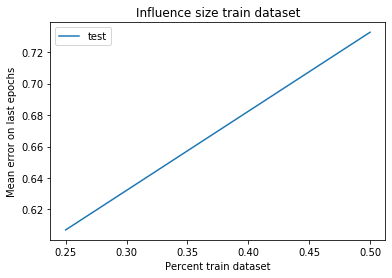

In [59]:

plt.figure()
lists = sorted(test_performances.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)

plt.title('Influence size train dataset')
plt.ylabel('Mean error on last epochs')
plt.xlabel('Percent train dataset')
plt.legend(['test'], loc='upper left')